In [7]:
import os

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.datasets import fashion_mnist
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras.utils import plot_model, to_categorical
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [8]:
df = pd.read_csv('archive/styles.csv', error_bad_lines=False)

# filter out columns that are not 'id' nor 'articleType'
df = df.filter(items=['id', 'articleType'])

<ipython-input-8-605ac20267b8>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('archive/styles.csv', error_bad_lines=False)
Skipping line 6044: expected 10 fields, saw 11
Skipping line 6569: expected 10 fields, saw 11
Skipping line 7399: expected 10 fields, saw 11
Skipping line 7939: expected 10 fields, saw 11
Skipping line 9026: expected 10 fields, saw 11
Skipping line 10264: expected 10 fields, saw 11
Skipping line 10427: expected 10 fields, saw 11
Skipping line 10905: expected 10 fields, saw 11
Skipping line 11373: expected 10 fields, saw 11
Skipping line 11945: expected 10 fields, saw 11
Skipping line 14112: expected 10 fields, saw 11
Skipping line 14532: expected 10 fields, saw 11
Skipping line 15076: expected 10 fields, saw 12
Skipping line 29906: expected 10 fields, saw 11
Skipping line 31625: expected 10 fields, saw 11
Skipping line 33020: expected 10 fields, saw 11


In [9]:
conversion = {
    "Tshirts": 0,
    "Tops": 0,
    "Lounge Tshirts": 0,
    "Jeans": 1,
    "Track Pants": 1,
    "Trousers": 1,
    "Lounge Pants": 1,
    "Leggings": 1,
    "Rain Trousers": 1,
    "Sweaters": 2,
    "Dresses": 3,
    "Waistcoat": 4,
    "Rain Jacket": 4,
    "Jackets": 4,
    "Nehru Jackets": 4,
    "Sandals": 5,
    "Sports Sandals": 5,
    "Shirts": 6,
    "Sweatshirts": 6,
    "Casual Shoes": 7,
    "Sports Shoes": 7,
    "Handbags": 8,
    "Duffel Bag": 8,
    "Booties": 9,
}


In [10]:
def preprocess_image(image_path):
    # Load the image
    image = cv.imread(image_path)

    # Threshold the image on all four channels to create a binary mask

    _, binary_mask = cv.threshold(image, 175, 255, cv.THRESH_BINARY_INV)

    # Convert the binary mask to 3 channels (BGR)
    bgr_mask = cv.cvtColor(binary_mask, cv.COLOR_RGBA2BGR)

    # Apply the binary mask to remove the background and make it black
    black_background_image = cv.bitwise_and(image, bgr_mask)

    # Convert the image to grayscale
    gray_image = cv.cvtColor(black_background_image, cv.COLOR_BGR2GRAY)

    # Resize the image to 28x28 pixels
    resized_image = cv.resize(gray_image, (28, 28), interpolation=cv.INTER_AREA)

    # Normalize the pixel values to range [0, 1]
    normalized_image = resized_image / 255.0

    return normalized_image

In [11]:
x = []
y = []
for i in range(len(df)):
    id = df.iloc[i, 0]
    articleType = df.iloc[i, 1]
    img_path = f'archive/images/{id}.jpg'
    exists = os.path.isfile(img_path)
    if articleType in conversion and exists:
        x.append(preprocess_image(f'archive/images/{id}.jpg'))
        y.append(conversion[articleType])


In [12]:
def plot_loss(history, model):
    plt.plot(history.history['loss'], label="Train")
    plt.plot(history.history['val_loss'], label="Validation")
    plt.title(f"{model} train and validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"./Losses/{model}.png")
    plt.show()
    return

In [13]:
# Load data
(x_train_and_val, y_train_and_val), (x_test, y_test) = fashion_mnist.load_data()

# Normalize data in 0-1 range
x_train_and_val = x_train_and_val / 255.0
y_train_and_val = to_categorical(y_train_and_val)

x_test = x_test / 255.0
y_test = to_categorical(y_test)

# x_train: uint8 NumPy array of grayscale image data with shapes (60000, 28, 28), containing the training data.

# y_train: uint8 NumPy array of labels (integers in range 0-9) with shape (60000,) for the training data.

# x_test: uint8 NumPy array of grayscale image data with shapes (10000, 28, 28), containing the test data.

# y_test: uint8 NumPy array of labels (integers in range 0-9) with shape (10000,) for the test data.
# building a validation set
train_size = int(x_train_and_val.shape[0] * 0.7)
validation_size = x_train_and_val.shape[0] - train_size

x_validation, y_validation = (x_train_and_val[train_size:], y_train_and_val[train_size:])
x_train, y_train = (x_train_and_val[:train_size], y_train_and_val[:train_size])

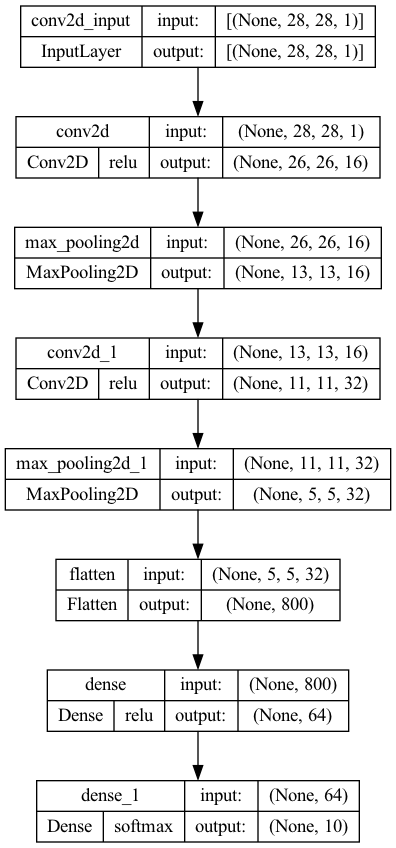

In [14]:
img_width = 28
img_height = 28
num_classes = 10
channels = 1
# Initialize the model
model = Sequential()

# Add a convolutional layer with 32 kernels, 3x3 kernel size, and ReLU activation function
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(img_width, img_height, channels)))

# Add a max pooling layer with 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add another convolutional layer with 64 kernels, 3x3 kernel size, and ReLU activation function
model.add(Conv2D(32, (3, 3), activation='relu'))

# Add a max pooling layer with 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output to a 1D array
model.add(Flatten())

# Add a fully connected layer with 128 neurons and ReLU activation function
model.add(Dense(64, activation='relu'))

# Add the output layer with a softmax activation function for multi-class classification
model.add(Dense(num_classes, activation='softmax'))

# Compile the model with categorical cross-entropy loss function and Adam optimizer with a learning rate of 0.001
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print a summary of the model architecture
# model.summary()
plot_model(model, show_shapes=True, show_layer_activations=True, to_file="./Models/baseline_model.png")

In [15]:
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs=15)

Epoch 1/15
1313/1313 [==============================] - 20s 15ms/step - loss: 0.5636 - accuracy: 0.7965 - val_loss: 0.4039 - val_accuracy: 0.8571
Epoch 2/15
1313/1313 [==============================] - 19s 14ms/step - loss: 0.3754 - accuracy: 0.8638 - val_loss: 0.3677 - val_accuracy: 0.8672
Epoch 3/15
1313/1313 [==============================] - 19s 14ms/step - loss: 0.3241 - accuracy: 0.8826 - val_loss: 0.3378 - val_accuracy: 0.8778
Epoch 4/15
1313/1313 [==============================] - 19s 14ms/step - loss: 0.2948 - accuracy: 0.8911 - val_loss: 0.3161 - val_accuracy: 0.8849
Epoch 5/15
1313/1313 [==============================] - 19s 14ms/step - loss: 0.2709 - accuracy: 0.9001 - val_loss: 0.2974 - val_accuracy: 0.8934
Epoch 6/15
1313/1313 [==============================] - 19s 14ms/step - loss: 0.2529 - accuracy: 0.9067 - val_loss: 0.2871 - val_accuracy: 0.8930
Epoch 7/15
1313/1313 [==============================] - 19s 14ms/step - loss: 0.2345 - accuracy: 0.9128 - val_loss: 0.2766 -

In [27]:
x = np.array(x)

In [33]:
y = to_categorical(np.array(y))

In [29]:
x.shape

(22754, 28, 28)

In [34]:
print('\nValidation accuracy:', history.history['val_accuracy'][-1])

# in depth evaluation
predictions = model.predict(x_validation)

# going back to labels
predictions = np.argmax(predictions, axis=1)
y_val = np.argmax(y_validation, axis=1)

confusion_matrix(y_val, predictions)

print("Precision: ", precision_score(y_val, predictions, average='macro'))
print("Recall: ", recall_score(y_val, predictions, average='macro'))
# testing

test_loss, test_acc = model.evaluate(x, y, verbose=2)

print('\nTest accuracy:', test_acc)

# in depth evaluation
predictions = model.predict(x)

# going back to labels
predictions = np.argmax(predictions, axis=1)
y_val = np.argmax(y, axis=1)

confusion_matrix(y_val, predictions)

print("Precision: ", precision_score(y_val, predictions, average='macro'))
print("Recall: ", recall_score(y_val, predictions, average='macro'))


Validation accuracy: 0.9084444642066956
563/563 [==============================] - 1s 2ms/step
Precision:  0.9094945119948857
Recall:  0.9088214629466084
712/712 - 6s - loss: 4.3975 - accuracy: 0.2216 - 6s/epoch - 8ms/step

Test accuracy: 0.22163134813308716
712/712 [==============================] - 2s 2ms/step
Precision:  0.2719165670425769
Recall:  0.266606689114413
